In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [3]:
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from datetime import datetime, timedelta

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

__Описания полей__
- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [6]:
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [20]:
df_test.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time
count,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000
mean,54945.647473,39.186002,0.268040,0.166772,-1.904152,2.014471,56.802938,1.573798,2.501087,40835.755729,1.728053,2.765798
std,31706.052195,11.513258,0.788478,0.372777,0.501764,2.296789,13.086646,0.527428,0.683227,43802.180951,1.120686,1.011560
min,4.000000,21.000000,0.000000,0.000000,-3.574197,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000
25%,27744.000000,30.000000,0.000000,0.000000,-2.261909,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000
50%,54657.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000
75%,82322.000000,48.000000,0.000000,0.000000,-1.563957,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000
max,110148.000000,71.000000,30.000000,1.000000,0.188820,47.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

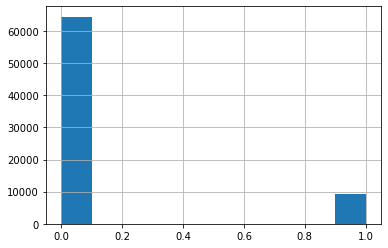

In [9]:
# Смотрим каких клиентов у банка больше: совершивших дефолт (1) или нет (0)
df_train.default.hist()

In [6]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = -1 # в тесте у нас нет значения default

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [34]:
round(df.education.count()/df.client_id.count()*100-100,2)

-0.43

In [35]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,-1
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,-1
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,-1
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,-1
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,-1


In [6]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,-0.244916
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.595908
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,-1.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,-1.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения и даты. Значит, нам необходима предварительная очистка данных.

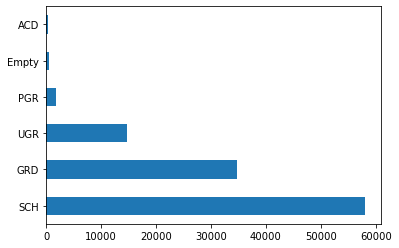

In [7]:
df.education = df.education.fillna('Empty')

# Смотрим распределение данных по уровню образования - больше всего случаев относятся к SCH
df.education.value_counts().plot.barh()

In [8]:
# Смотрим как соотносятся поаказатели уровня образования, пола и возраста
educ_age_sex = df.groupby(['sex','education'])['age'].agg(['mean','median','count'])
educ_age_sex

mean  median  count
sex education                          
F   ACD        40.052174      38    115
    Empty      42.438462      42    260
    GRD        38.534372      36  18940
    PGR        38.485651      37    906
    SCH        42.945311      42  33663
    UGR        35.918888      33   7952
M   ACD        40.500000      37    176
    Empty      40.243119      39    218
    GRD        37.506823      35  15828
    PGR        38.644421      36    959
    SCH        38.483049      37  24335
    UGR        33.622131      31   6796

In [7]:
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = -1 # в тесте у нас нет значения default

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# В случае с женщинами наиболее подходящая замена пустот - SCH
df.loc[df['sex']=='F'] = df.loc[df['sex']=='F'].fillna('SCH')
# В случае с мужчинами наиболее подходящая замена пустот - ACD
df.loc[df['sex']=='M'] = df.loc[df['sex']=='M'].fillna('ACD')

In [42]:
df.app_date.describe()

count        110148
unique          120
top       18MAR2014
freq           1491
Name: app_date, dtype: object

In [10]:
# превращаем данные в даты
df['app_date'] = df['app_date'].dropna().apply(lambda x: pd.to_datetime(x))

In [45]:
df.app_date.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  110148
unique                    120
top       2014-03-18 00:00:00
freq                     1491
first     2014-01-01 00:00:00
last      2014-04-30 00:00:00
Name: app_date, dtype: object

У нас есть данные всего за 4 месяца. И 18 Марта попадается чаще всего.

In [11]:
# выделим месяц
df['app_date_month'] = df['app_date'].dropna().apply(lambda x: x.month)

In [13]:
print(df.client_id.count())
print(df.client_id.nunique())
# каждый клиент встречается по одному разу

110148
110148


In [14]:
# Минимальное значение у score_bki отрицательно 
# чтобы его можно было прологарифмировать данные, увеличим каждое на модуль минимального значения
df['score_bki'] = df['score_bki'].dropna().apply(lambda x: x - df['score_bki'].min())

In [15]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_date_month
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,1.352703,...,50,1,2,50000,1,4,N,0,-1,3
1,17527,2014-01-24,SCH,F,39,N,N,5,0,2.119587,...,50,1,2,5000,4,3,N,0,-1,1
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,1.933247,...,50,1,2,30000,1,3,Y,0,-1,3
3,26883,2014-02-03,SCH,M,56,N,N,0,0,1.250404,...,40,1,2,17000,1,3,N,0,-1,2
4,28862,2014-02-04,GRD,F,38,N,N,0,0,1.137084,...,80,2,3,120000,1,3,N,0,-1,2


In [16]:
# Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) 
# для дальнейшего удобного анализа.

# бинарные переменные
bin_cols = ['sex','car','car_type','foreign_passport','good_work']
# категориальные переменные
cat_cols = ['education','home_address','work_address','sna','first_time','region_rating','app_date_month']
# числовые переменные
num_cols = ['age','decline_app_cnt','income','bki_request_cnt','score_bki']
# временные ряды
num_date = ['app_date']
# sumission
sub_cols = ['client_id','default']

In [17]:
# Строим графики распределения числовых данных:
def get_plot(data, col):
    plt.figure()
    sns.distplot(data[col][data[col] > 0].dropna(), kde = False, rug=False)
    plt.title(col)
    plt.show()
    print('Минимум: {}\nМаксимум: {}'.format(data[col].min(), data[col].max()))

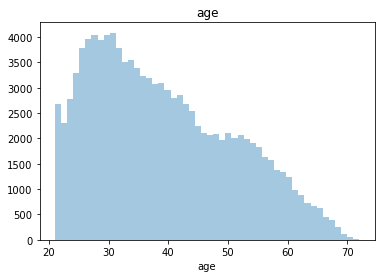

Минимум: 21
Максимум: 72


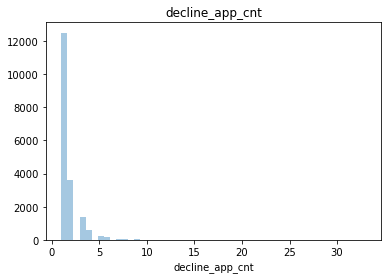

Минимум: 0
Максимум: 33


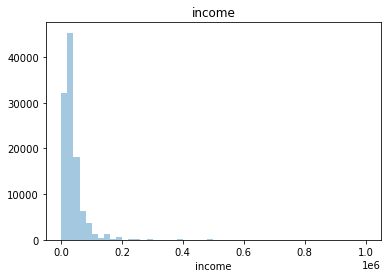

Минимум: 1000
Максимум: 1000000


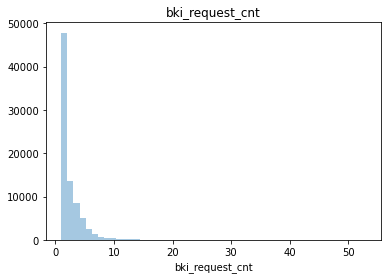

Минимум: 0
Максимум: 53


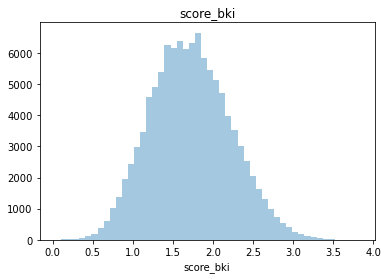

Минимум: 0.0
Максимум: 3.82435917


In [53]:
# Посмотрим на распределение числовых данных:
for i in num_cols:
    get_plot(df, i)

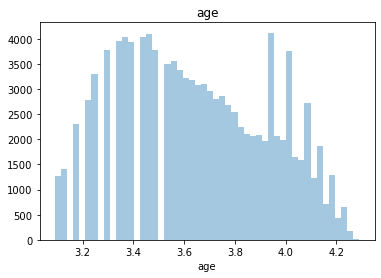

Минимум: 3.091042453358316
Максимум: 4.290459441148391


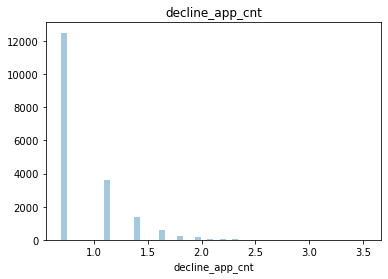

Минимум: 0.0
Максимум: 3.5263605246161616


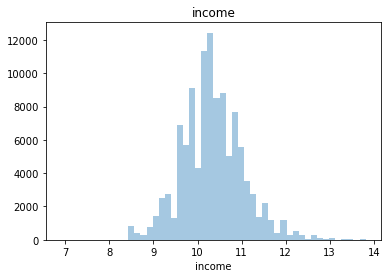

Минимум: 6.90875477931522
Максимум: 13.815511557963774


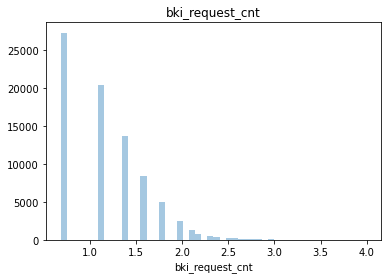

Минимум: 0.0
Максимум: 3.9889840465642745


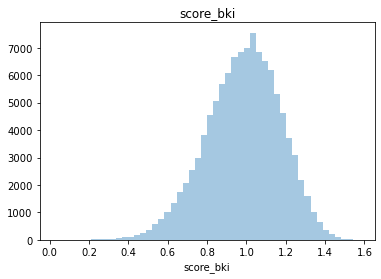

Минимум: 0.0
Максимум: 1.5736779114625494


In [54]:
# очевидно, что распределения всех числовых переменных имеют тяжёлый правый хвост
# Построим графики распределения логарифмированных переменных.

df_log = df.copy()

for i in num_cols:
    df_log[i] = np.log(df_log[i]+1)
    get_plot(df_log, i)

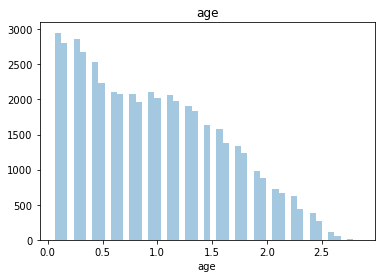

Минимум: -1.5844238142384632
Максимум: 2.8434242661041864


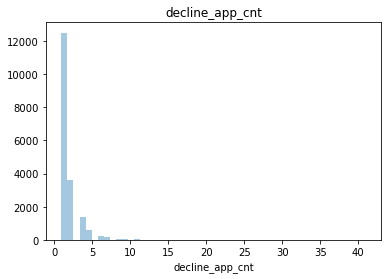

Минимум: -0.3418928984926288
Максимум: 40.954788271363505


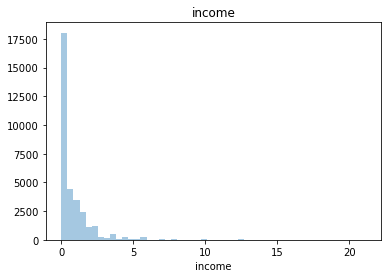

Минимум: -0.881345014981568
Максимум: 21.123288573897163


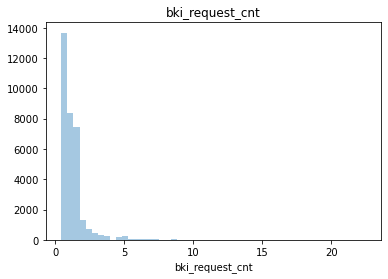

Минимум: -0.8844627391266779
Максимум: 22.495322790376743


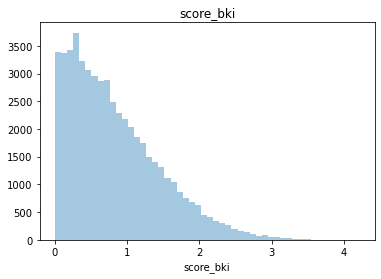

Минимум: -3.444268554193629
Максимум: 4.2137124897115825


In [55]:
# Некоторые переменные (age, income) стали менее смещёнными.
# Такой принцип можно применить перед построением модели и сравнить значение метрики.
# Построим графики распределения стандартизированных переменных.
df_std = df.copy()

X_num = StandardScaler().fit_transform(df_std[num_cols].values)

df_std_1 = pd.DataFrame(X_num, columns=num_cols)

for i in num_cols:
    get_plot(df_std_1, i)

In [18]:
# Логарифмированные данные выглядят лучше (или я что-то не так сделала со стандартизацией)
# буду пользоваться ими
for i in num_cols:
    df[i] = np.log(df[i] + 1)
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_date_month
0,74835,2014-03-22,GRD,M,3.401197,Y,Y,0.000000,0,0.855565,...,50,1,2,10.819798,1,4,N,0,-1,3
1,17527,2014-01-24,SCH,F,3.688879,N,N,1.791759,0,1.137701,...,50,1,2,8.517393,4,3,N,0,-1,1
2,75683,2014-03-23,UGR,M,3.931826,Y,Y,0.000000,0,1.076110,...,50,1,2,10.308986,1,3,Y,0,-1,3
3,26883,2014-02-03,SCH,M,4.043051,N,N,0.000000,0,0.811110,...,40,1,2,9.741027,1,3,N,0,-1,2
4,28862,2014-02-04,GRD,F,3.663562,N,N,0.000000,0,0.759442,...,80,2,3,11.695255,1,3,N,0,-1,2


In [19]:
# Построим распределение числовых переменных по целевой переменной и на выбросы
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

def get_descript(data, column):
    
    def get_boxplot(data, column):   # График
        fig, ax = plt.subplots()
        sns.boxplot(x='default', y=column, data = data)
        ax.set_title('Boxplot for ' + column)
        plt.show()
    
    def outliers_z_score(data, column, threshold=3): # Поиск по отклонению (z-score)
        mean_y = np.mean(data[column])
        std_y = np.std(data[column])
        z_scores = [(y - mean_y) / std_y for y in data[column]]
        otl_z = np.where(np.abs(z_scores) > threshold)[0]
        return print('Количество выбросов по z-score: {}\n% выбросов по z-score: {}'.format(len(otl_z), round(len(otl_z)/data[column].count()*100,2)))

    def outliers_iqr(data, column):   # Поиск по IQR
        quartile_1, quartile_3 = np.percentile(data[column], [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        lower_otl_q = np.where(data[column] < lower_bound)[0]
        upper_bound = quartile_3 + (iqr * 1.5)
        upper_otl_q = np.where(data[column] > upper_bound)[0]
        return print('Количество выбросов снизу по IQR: {}\nКоличество выбросов сверху по IQR: {}'.format(len(lower_otl_q), len(upper_otl_q)))

    return [get_boxplot(data, column), outliers_z_score(data, column), outliers_iqr(data, column)]

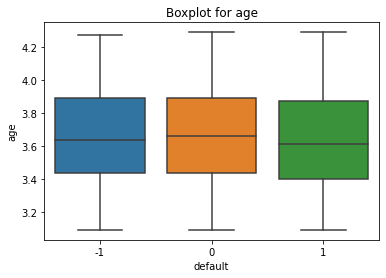

Количество выбросов по z-score: 0
% выбросов по z-score: 0.0
Количество выбросов снизу по IQR: 0
Количество выбросов сверху по IQR: 0


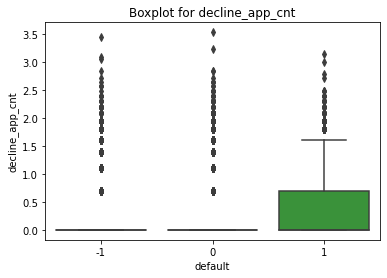

Количество выбросов по z-score: 2555
% выбросов по z-score: 2.32
Количество выбросов снизу по IQR: 0
Количество выбросов сверху по IQR: 18677


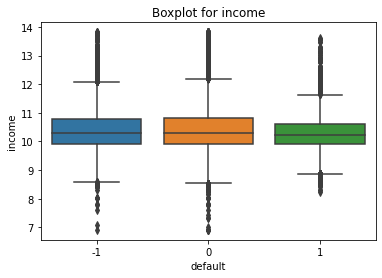

Количество выбросов по z-score: 743
% выбросов по z-score: 0.67
Количество выбросов снизу по IQR: 875
Количество выбросов сверху по IQR: 1734


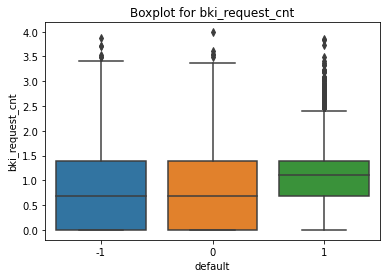

Количество выбросов по z-score: 197
% выбросов по z-score: 0.18
Количество выбросов снизу по IQR: 0
Количество выбросов сверху по IQR: 15


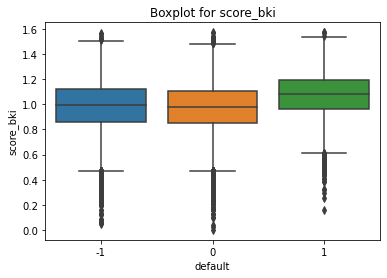

Количество выбросов по z-score: 361
% выбросов по z-score: 0.33
Количество выбросов снизу по IQR: 681
Количество выбросов сверху по IQR: 31


In [27]:
for i in num_cols:
    get_descript(df, i)

Выводы:
- Дефолтные клиенты в среднем __младше__
- Дефолтные клиенты в среднем имеют __большое__ количество отмененных заявок
- Дефолтные клиенты в среднем имеют __больше__ запросов в БКИ
- Дефолтные клиенты в среднем имеют более __низкий__ доход
- Дефолтные клиенты в среднем имеют более __высокий__ скоринговый балл

+ Достаточно много выбросов

##### Оценка корреляций: 
Сильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

__Как работать с корреляцией?__

- ___Способ 1.___ Отобрать низко коррелируемые признаки .
- ___Способ 2.___ Использовать регуляризацию, чтобы в процессе обучения штрафовать модель за сложность, выраженную в величине весов, при этом задавая величину штрафа. Изменяя эту величину, я смогу контролировать переобучение и устойчивость модели.

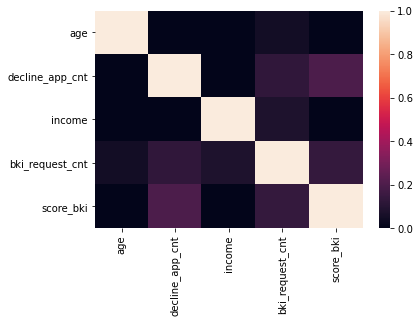

In [60]:
# Оценим корреляцию для непрерывных переменных
sns.heatmap(df[num_cols].corr(), vmin=0, vmax=1)

In [61]:
df[num_cols].corr()

,age,decline_app_cnt,income,bki_request_cnt,score_bki
age,1.000000,-0.128624,-0.090734,0.050241,-0.110827
decline_app_cnt,-0.128624,1.000000,-0.013959,0.127531,0.200194
income,-0.090734,-0.013959,1.000000,0.078649,-0.002753
bki_request_cnt,0.050241,0.127531,0.078649,1.000000,0.140561
score_bki,-0.110827,0.200194,-0.002753,0.140561,1.000000


Выводы:
1. У нас есть несколько пар показателей с существенной корреляцией:
    - обратная зависимость ___скорингового балла___ от ___возраста___ (-0,11)
    - прямая зависимость ___скорингового балла___ от ___количества отмененных заявок___ (0,20)
    - прямая зависимость ___скорингового балла___ от ___количества запросов в БКИ___ (0,14)
    - обратная зависимость ___количества отмененных заявок___ от ___возраста___ (-0,13)
    - прямая зависимость ___количества отмененных заявок___ от ___количества запросов в БКИ___ (0,13)
2. Но ни одна из них не является настолько сильной, чтобы создать проблемы в линейной модели.

##### Значимость непрерывных переменных

Возможности модуля ___sklearn.feature_selection___ могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит ___однофакторный дисперсионный анализ (ANOVA)___. Основу процедуры составляет обобщение результатов двух выборочных ___t-тестов___ для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение ___f-статистики___. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

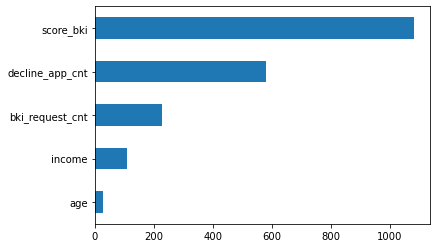

In [20]:
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Выводы:
1. ___скоринговый балл___ - самый важный из количественных признаков;
2. ___возраст___ - наименее важный из количественных признаков.

##### Категориальные переменные

In [21]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_date_month
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,0.855565,...,50,1,2,10.819798,1,4,0,0,-1,3
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,1.137701,...,50,1,2,8.517393,4,3,0,0,-1,1
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,1.076110,...,50,1,2,10.308986,1,3,1,0,-1,3
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,0.811110,...,40,1,2,9.741027,1,3,0,0,-1,2
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,0.759442,...,80,2,3,11.695255,1,3,0,0,-1,2


Для оценки __значимости категориальных и бинарных переменных__ будем использовать функцию ___mutual_info_classif___ из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

___mutual_info_classif___ сначала требует, чтобы категориальные значения были сопоставлены с целочисленными значениями

In [22]:
education_code = {}
counter = 0
for abv in df['education'].unique():
    counter += 1
    education_code.setdefault(abv, counter)
df['education'] = df['education'].apply(lambda x: education_code[x])

# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_date_month
0,74835,2014-03-22,1,1,3.401197,1,1,0.000000,0,0.855565,...,50,1,2,10.819798,1,4,0,0,-1,3
1,17527,2014-01-24,2,0,3.688879,0,0,1.791759,0,1.137701,...,50,1,2,8.517393,4,3,0,0,-1,1
2,75683,2014-03-23,3,1,3.931826,1,1,0.000000,0,1.076110,...,50,1,2,10.308986,1,3,1,0,-1,3
3,26883,2014-02-03,2,1,4.043051,0,0,0.000000,0,0.811110,...,40,1,2,9.741027,1,3,0,0,-1,2
4,28862,2014-02-04,1,0,3.663562,0,0,0.000000,0,0.759442,...,80,2,3,11.695255,1,3,0,0,-1,2


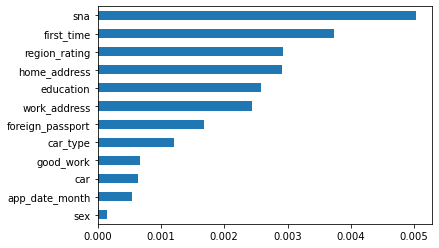

In [23]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Выводы:
1. ___связь заемщика с клиентами банка___ - самый важный из категориальных признаков;
2. ___пол___ - наименее важный из категориальных признаков.

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

In [34]:
# Количество dummy-признаков
x = 0
for col in cat_cols:
    x += df[col].value_counts().count()
x

30

In [24]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
np.shape(X_cat)

(110148, 30)

In [25]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(df[num_cols].values)
np.shape(X_num)

(110148, 5)

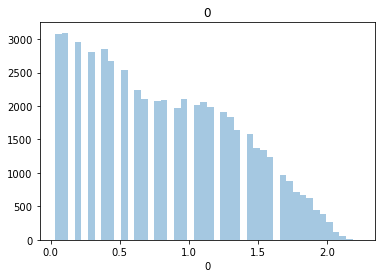

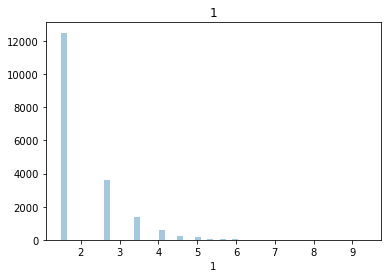

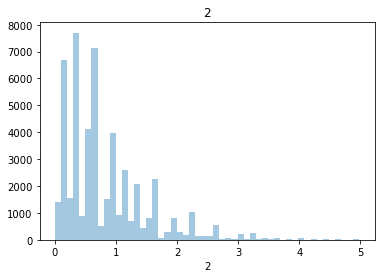

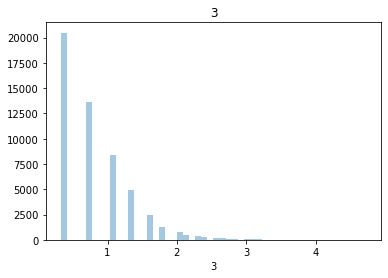

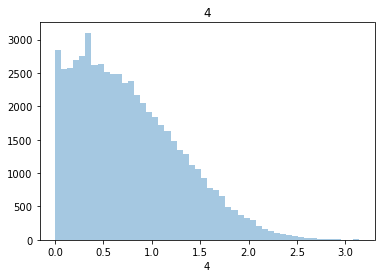

In [26]:
X_num_df = pd.DataFrame(X_num)

for i in X_num_df:
    plt.figure()
    sns.distplot(X_num_df[i][X_num_df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [27]:
print(np.shape(df[bin_cols].values))
print(np.shape(df['sample'].values))
print(df['sample'][:36348].describe())
print(df['sample'][36349:].describe())

(110148, 5)
(110148,)
count    36348.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: sample, dtype: float64
count    73799.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: sample, dtype: float64


In [28]:
# Объединяем логарифмированные (стандартизированные мне так и не понравились) числовые, бинарные и 
# закодированные категориальные переменные в одно признаковое пространство
df_new = np.hstack([df[num_cols].values, df[bin_cols].values, X_cat])

# МОДЕЛЬ

In [140]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = -1 # в тесте у нас нет значения default

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

c_test = df_test['sample'].count()
c_train = df_train['sample'].count()

print(c_test, c_train)

36349 73799


In [163]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    # Избавляемся от пустот
    # В случае с женщинами наиболее подходящая замена пустот - SCH
    df_output.loc[df_output['sex']=='F'] = df_output.loc[df_output['sex']=='F'].fillna('SCH')
    # В случае с мужчинами наиболее подходящая замена пустот - ACD
    df_output.loc[df_output['sex']=='M'] = df_output.loc[df_output['sex']=='M'].fillna('ACD')
    
    # Работаем с датами
    # превращаем данные в даты
    df_output['app_date'] = df_output['app_date'].dropna().apply(lambda x: pd.to_datetime(x))
    # выделим месяц
    df_output['app_date_month'] = df_output['app_date'].dropna().apply(lambda x: x.month)
    
    # Минимальное значение у score_bki отрицательно 
    # чтобы его можно было прологарифмировать данные, увеличим каждое на модуль минимального значения
    df_output['score_bki'] = df_output['score_bki'].dropna().apply(lambda x: x - df_output['score_bki'].min())
    
    # Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) 
    # для дальнейшего удобного анализа.

    # бинарные переменные
    bin_cols = ['sex','car','car_type','foreign_passport','good_work']
    # категориальные переменные
    cat_cols = ['education','home_address','work_address','sna','first_time','region_rating','app_date_month']
    # числовые переменные
    num_cols = ['age','decline_app_cnt','income','bki_request_cnt','score_bki']
    
    # Избавимся от показателей с малой долей влияния
    # бинарные переменные
    #bin_cols = ['car','car_type','foreign_passport','good_work']
    # категориальные переменные
    #cat_cols = ['education','home_address','work_address','sna','first_time','region_rating']
    # числовые переменные
    #num_cols = ['decline_app_cnt','income','bki_request_cnt','score_bki']
    
    # Логарифмируем данные
    for i in num_cols:
        df_output[i] = np.log(df_output[i] + 1)
    
    # Избавимся от выбрасов в одном из самых важных для нас параметрах
    #quartile_1, quartile_3 = np.percentile(df_output['score_bki'], [25, 75])
    #iqr = quartile_3 - quartile_1
    #lb = quartile_1 - (iqr * 1.5)
    #ub = quartile_3 + (iqr * 1.5)
    
    #df_output['score_bki'] = df_output['score_bki'].apply(lambda x: x if lb<x and x<ub else (x==lb if x<lb else x==ub))
    
    # Стандартизация числовых переменных
    X_num = StandardScaler().fit_transform(df_output[num_cols].values)
    
    # Для бинарных признаков мы будем использовать LabelEncoder
    label_encoder = LabelEncoder()
    for column in bin_cols:
        df_output[column] = label_encoder.fit_transform(df_output[column])
    
    education_code = {}
    counter = 0
    for abv in df_output['education'].unique():
        counter += 1
        education_code.setdefault(abv, counter)
    df_output['education'] = df_output['education'].apply(lambda x: education_code[x])

    X_cat = OneHotEncoder(sparse = False).fit_transform(df_output[cat_cols].values)
    
    # Объединяем логарифмированные (стандартизированные мне так и не понравились) числовые, бинарные и 
    # закодированные категориальные переменные в одно признаковое пространство
    #df_output = np.hstack([df_output[num_cols].values, df_output[bin_cols].values, X_cat])
    df_output = np.hstack([X_num, df_output[bin_cols].values, X_cat])
    
    return df_output

In [164]:
df_new = preproc_data(df)
df_new.shape

(110148, 40)

In [165]:
# Теперь выделим тестовую часть
train_df = df_new[c_test:]
test_df = df_new[:c_test]

# разделив при этом признаки и целевую переменную.
X = train_df
Y = df['default'][c_test:].values # Наша целевая переменная

In [166]:
X_test = test_df
y_test = df['default'][:c_test].values
X_test.shape, y_test.shape

((36349, 40), (36349,))

In [167]:
# Разделим данные для обучения валидации
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.20, random_state=42)

In [168]:
# проверяем
train_df.shape, test_df.shape, X.shape, X_train.shape, X_valid.shape, y_valid.shape

((73799, 40), (36349, 40), (73799, 40), (59039, 40), (14760, 40), (14760,))

In [169]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

Доля положительных результатов у «плохих» заемщиков (истинно положительных результатов) — это чувствительность модели (Sensitivity), то есть способность модели правильно определять «плохих» заемщиков и минимизировать убытки, связанные с выдачей кредита «плохому» клиенту. 

Доля отрицательных результатов у «хороших» заемщиков (истинно отрицательных результатов) — это специфичность модели (Specificity). Здесь речь уже идёт о способности модели правильно определять «хороших» заемщиков и минимизировать убытки, связанные с отказом в выдаче кредита добросовестному клиенту.

In [170]:
def get_roc_auc(X, y, model):
    y_pred_prob = model.predict_proba(X)[:,1]
    y_pred = model.predict(X)

    fpr, tpr, threshold = roc_curve(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    preds = model.predict(X)
    print('F1: %.4f' % f1_score(y, preds))
    
    conf_mat = pd.DataFrame(confusion_matrix(y, y_pred).T)
    plt.figure(figsize = (10,7))
    sns.heatmap(conf_mat)
    display(conf_mat)

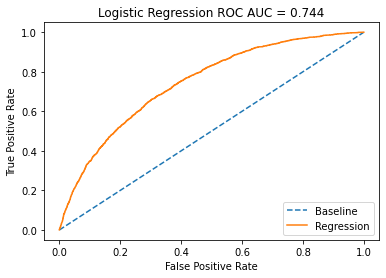

F1: 0.0385


,0,1
0,12875,1790
1,58,37


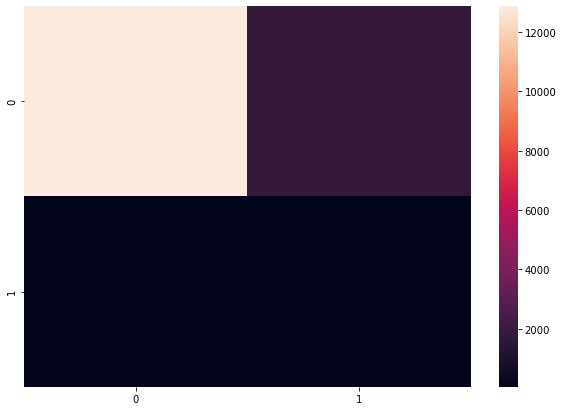

In [171]:
get_roc_auc(X_valid, y_valid, model_1)

Дефолты модель явно не определяет

#### РЕГУЛЯРИЗАЦИЯ

__Гиперпараметры__ — это внешние параметры для классификатора, которые не могут быть изучены самим классификатором и чаще всего задаются вручную. Логистическая регрессия, например, не способна сама выучить наилучшее значение для, например, ___параметра С___.  В scikit-learn они передаются в качестве аргументов конструктору класса. Найдя оптимальные параметры, мы можем улучшить предсказательную силу нашей логистической регрессии.

In [44]:
# Давайте найдем оптимальное значение параметра регуляризации для логистической регрессии.
# поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидацией
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=42)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_valid)
print('Accuracy: %.4f' % accuracy_score(y_valid, preds))
print('Precision: %.4f' % precision_score(y_valid, preds))
print('Recall: %.4f' % recall_score(y_valid, preds))
print('F1: %.4f' % f1_score(y_valid, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6694
Precision: 0.2252
Recall: 0.6847
F1: 0.3390


In [195]:
model_reg = LogisticRegression(penalty='l2', dual=False, tol=0.001, C=5.0, fit_intercept=True,
                               intercept_scaling=1, class_weight='balanced', max_iter=50,
                               solver='sag', multi_class='multinomial', verbose=0, random_state=42,
                               warm_start=False, n_jobs=None, l1_ratio=None)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


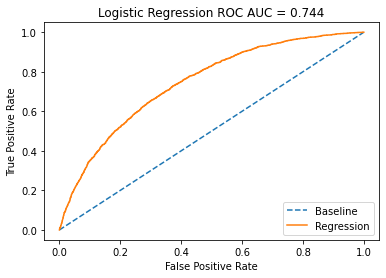

F1: 0.3390


,0,1
0,8620,574
1,4313,1253


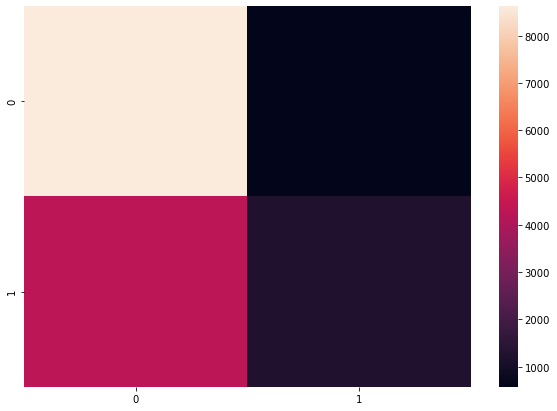

In [196]:
model_reg.fit(X_train, y_train)
get_roc_auc(X_valid, y_valid, model_reg)

In [197]:
# Переносим модель на тестовые данные
y_pred_prob_def = model_reg.predict_proba(X_test)[:,1]
y_pred_def = model_reg.predict(X_test)
display(y_pred_prob_def[:5])
display(y_pred_def[:5])
display(y_pred_prob_def.shape)
display(y_pred_def.shape)

array([0.22741087, 0.78833786, 0.33664394, 0.39673951, 0.13275427])

array([0, 1, 0, 0, 0])

(36349,)

(36349,)

In [86]:
# Формируем submission
submission_test = pd.DataFrame(df['client_id'][:c_test],
                              columns = ['client_id'])
# submission_test['default'] = 0
submission_test['default'] = y_pred_prob_def
display(submission_test.head())
display(submission_test.info())

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


None

In [ ]:
submission_test.to_csv('submission.csv', index=False)
submission_test.head(10)

In [67]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
